# Analysis of HOIs generated with a simple operation as multiplication or copy

In the following lines we reproduce a simple scenario in which we have 6 features, 3 of them presenting some interdependencies with a target and 3 of them independent from the target. For instance in the case presented in this notebook, we have: 
 
 - a redundant/synergistic interaction between variables 0,1,2 and the target; 
 
 - a synergystic/redundant interaction within the multiplet of variables 3,4,5 that is independent from the target.

 We also generate the evolution of this interdependencies on a third dimension, following the shape of an hanning window.

In [47]:
import numpy as np
from numpy import random
import hoi
import matplotlib.pyplot as plt

from frites.utils import parallel_func


from utils import oinfo_min, goinfo_create_fit, goinfo_create_fit_correction

In [48]:

#the target variable can be multivariate
target = random.multivariate_normal([0,0],[[1,0],[0,1]], 300).T
n_samples = 300
n_features = 12

data = np.zeros((n_features, n_samples))

data[0] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[1] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[2] =  random.normal(loc=0.0, scale=1.0, size=n_samples)

target[0] = (data[0] + data[1] + data[2])

data[3] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[4] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[5] = data[3] + data[4]

data[6] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]
data[7] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]
data[8] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + target[1]


data[9] =  random.normal(loc=0.0, scale=1.0, size=n_samples)
data[10] =  random.normal(loc=0.0, scale=1.0, size=n_samples) + data[9]
data[11] = random.normal(loc=0.0, scale=1.0, size=n_samples) + data[9]

data = data.T

#Here we generate the evolution on a third dimension, that can be the imagined as the time in a neuroscientific framework.
n_variable = 100
variables=np.arange(100)

data_random=np.broadcast_to(np.random.multivariate_normal(np.zeros(n_features), np.identity(n_features), n_samples)[:,:,np.newaxis], (n_samples, n_features, n_variable))

#hanning windows that we used to model the evolution of the interdependencies on a third dim
han = np.broadcast_to(np.hanning(n_variable), (n_samples, n_features, n_variable))

data_features = np.broadcast_to(data[:,:,np.newaxis], (n_samples, n_features, n_variable))* han + (1-han) * data_random


How to compute HOIs ?

In [50]:
# Here we define min and max order that we want to compute

minsize=2
maxsize=6

#Here we create a 
model = hoi.metrics.GradientOinfo(data_features, target.T)
goinfo = model.fit(minsize=minsize, maxsize=maxsize)



    Copnorm data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

    Copnorm data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

How to plot the evolution on time of HOIs

Get list of multiplets


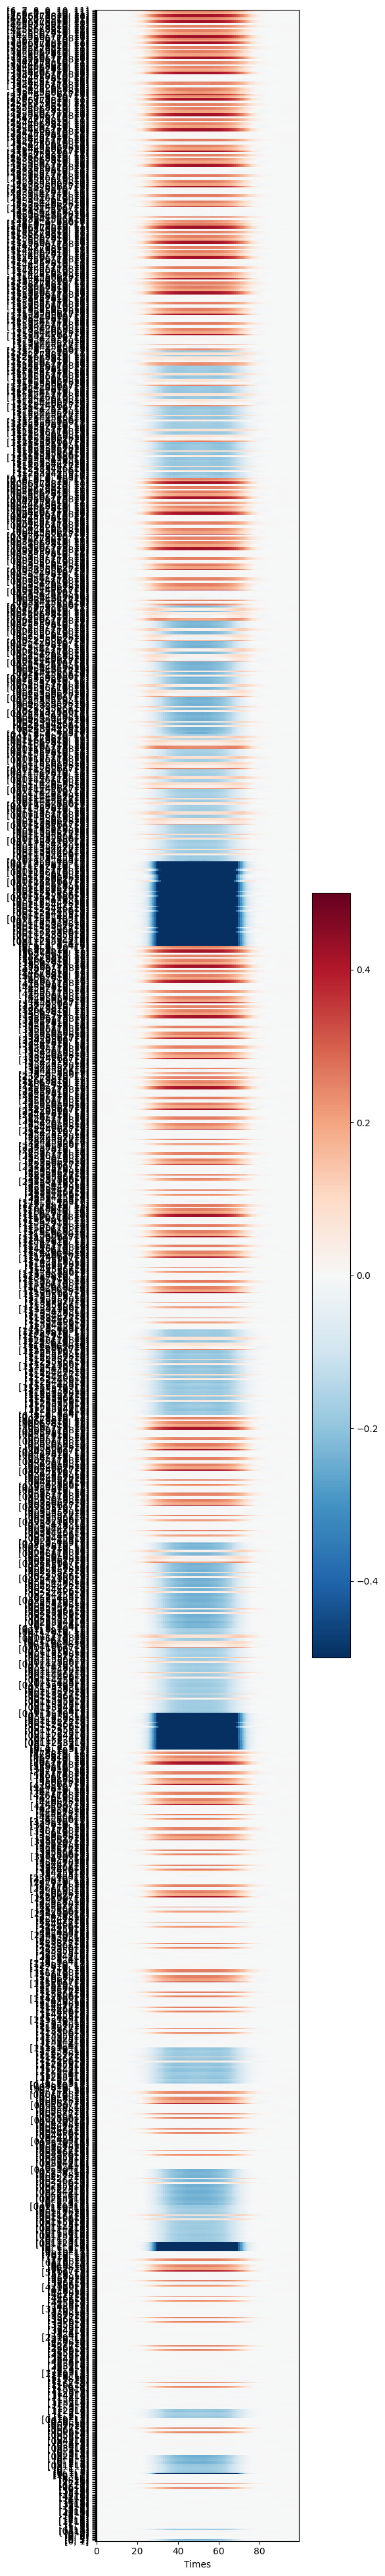

In [51]:
combos=model.get_combinations(minsize=minsize, maxsize=maxsize)[0]
list_indices=[[int(c) for c in comb if c != -1] for comb in combos]
list_multiplets=[str([int(i) for i in comb]) for comb in list_indices]

vmin, vmax = -0.5,0.5

plt.figure(figsize=(5,50))
plt.pcolormesh(
    variables, list_multiplets, goinfo, cmap='RdBu_r', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.show()
plt.close()

## higher-order spreading ? 

It is possible to notice in this simple scenario that we can measure a strong value of O information (or gradient of O information between features and target O(target, features) - O(features) ) between n variables, also when one of this variable is independent from the others. For example we observe a strong synergy between variables (0,1,2,3,4), even if we know that 3 and 4 are statistically independent from the rest. 

## A better formulation of the problem, using the O-information

It is simple to prove that if avariable $X_i$ is independent from the others we have: $\Omega(X_1, ..., X_{i-1}, X_i) = \Omega(X_1, ..., X_{i-1})$. Now, if the variable {$X_1, ..., X_{i-1}$} are presenting a strong synergistic/redundant O-information, when we study {$X_1, ..., X_{i-1}, X_i$}, we will observe the same value of synergistic/redudant O-information. To not consider the fact that the submultiplet {$X_1, ..., X_{i-1}$} is explaining the O information of the multiplet {$X_1, ..., X_{i-1}, X_i$} may lead to think that there is some synergy among all the variables of the multiplet, that is not the case. 

## A possible way out

A possible way to a (possibly) more accurate formulation is the following: if we want to know that the synergy/redundancy of the multiplets {$X_1, ..., X_{i-1}, X_i$} is involving all the variables, i.e. it is not due to a submultiplets effect, we have to check that, if we exclude from the computation of O information $X_i$, we have the same effect (decrease of synergy/redundancy) as when excluding all the other variable $X_j, j\in\{1,2, ...,n\}$. 

For the following part we will consider: 
$ X^n = \{X_1, ..., X_{i-1}, X_{i},..., X_n\}$ and $ X^n_{-i} = \{X_1, ...,  X_{i-1}, X_{i+1}, ..., X_n\}$

In formulas we want to check that for each i, $\Omega(X^n)-\Omega(X^n_{-i}) <0 $ in the case of synergy, $>0$ in the case of redundancy. Then, if we are interested in the value of the genuine O information (i.e. not due to submultiplet), we can consider taking:

$$sign(\Omega(X^n)-\Omega(X^n_{-i}))*min_i(|\Omega(X^n)-\Omega(X^n_{-i})|) \ \ \ \ if \ \ \  \ |\sum_i^n sign(\Omega(X^n)-\Omega(X^n_{-i}))| = n$$

Another possibilities should be:

$$sign(\Omega(X^n)-\Omega(X^n_{-i})) * \prod_i(|\Omega(X^n)-\Omega(X^n_{-i})|) \ \ \ \ if \ \ \ \ |\sum_i^n sign(\Omega(X^n)-\Omega(X^n_{-i}))| = n$$

Where  $ X^n = \{X_1, ..., X_{i-1}, X_{i},..., X_n\}$ and $ X^n_{-i} = \{X_1, ...,  X_{i-1}, X_{i+1}, ..., X_n\}$

For the product, there is the problem that is vanishing ... 

All of this can be generalised to the gradient of O information, as used in the toolbox to investigate the relationship between features and target.





Get list of multiplets


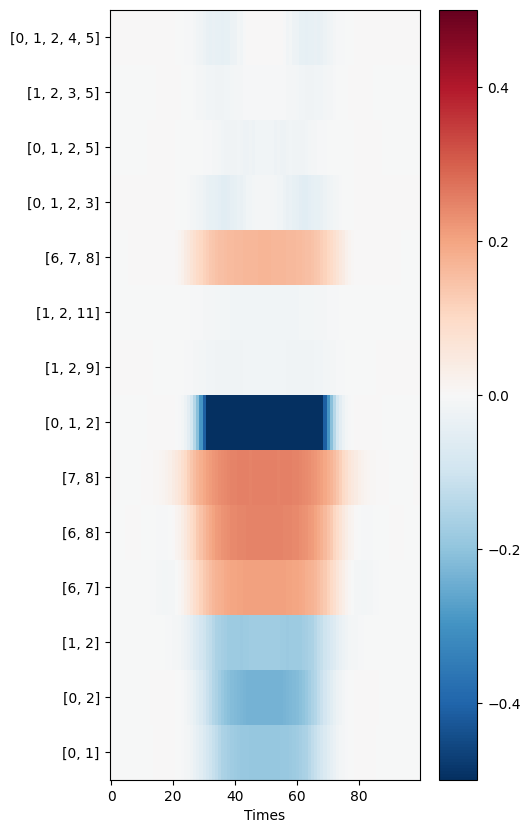

In [52]:
combos=model.get_combinations(minsize=minsize, maxsize=maxsize)[0]
list_indices=[[int(c) for c in comb if c != -1] for comb in combos]
list_multiplets=[str([int(i) for i in comb]) for comb in list_indices]

#Here we use the function defined in utils to "clean" the higher-order spreading
goinfo_proc=oinfo_min(goinfo, list_indices, minsize=2)
vmin, vmax = -0.5,0.5

plt.figure(figsize=(5,10))
index=np.where(np.sum(np.abs(goinfo_proc), axis=1)>0.5)[0]
plt.pcolormesh(
    variables, np.array(list_multiplets)[index], goinfo_proc[index, :], cmap='RdBu_r', vmin=vmin, vmax=vmax
)

plt.colorbar()
plt.xlabel('Times')
plt.show()
plt.close()

## Statistics, permutation test

To simulate the same situation as in the real scenario, we simulate the data of different subjects and perform our statistical pipeline.

True values of Oinfo

In [53]:
goinfo=goinfo_create_fit(data_features, target.T, minsize=minsize, maxsize=maxsize)


    Copnorm data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

    Copnorm data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

In [54]:
n_perm=500

parallel, p_fun = parallel_func(goinfo_create_fit, n_jobs=-1, total=n_perm)

perm = parallel(p_fun(data_features, np.random.permutation(target.T), minsize=minsize, maxsize=maxsize) for n_p in range(n_perm))

perm=np.array(perm)

  0%|          |  : 0/500 [00:00<?,       ?it/s]

    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
Get list of multiplets
  0%|          |  0/5 [00:00<?,       ?it/s]Get list of multiplets
    Copnorm data
    Copnorm data
Get list of multiplets
    Copnorm data
Get list of multiplets
  0%|          |  0/5 [00:00<?,       ?it/s]    Copnorm data
Get list of multiplets
  0%|          |  0/5 [00:00<?,       ?it/s]Get list of multiplets
    Copnorm data
  0%|          |  0/5 [00:00<?,       ?it/s]    Copnorm data
Get list of multiplets
  0%|          |  0/5 [00:00<?,       ?it/s]Get list of multiplets
Get list of multiplets
  0%|          |  0/5 [00:00<?,       ?it/s]    Copnorm data
Get list of multiplets
Get list of multiplets
  0%|          |  0/5 [00:00<?,       ?it/s]Get list of multiplets
Get list of multiplets
  0%|          |  0/5 [00:00<?,       ?it/s]Get list of multiplets
    Copnorm data                                      

In [ ]:
x

# creating the list for the permutation statistical test

 effect : list
    True effect list of length (n_roi,) composed of arrays each one of
    shape (n_subjects, ..., n_times). Number of subjects per ROI could
    be different

perms : list
    Permutation list of length (n_roi,) composed of arrays each one of
    shape (n_perm, n_subjects, ..., n_times). Number of subjects per
    ROI could be different

inference : {'ffx', 'irfx'}
    Perform either Fixed-effect ('ffx') or Random-effect ('rfx')
    inferences. By default, random-effect is used

mcp : {'cluster', 'maxstat', 'fdr', 'bonferroni', 'nostat', None}
    Method to use for correcting p-values for the multiple comparison
    problem. Use either : 

In [55]:
effect_list=[goinfo[np.newaxis, i,:] for i in range(len(goinfo[:,0]))]
perm_list=[perm[:,np.newaxis, i,:] for i in range(len(goinfo[:,0]))]

In [56]:
from frites.workflow import WfStats


In [57]:
inference='ffx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(effect_list, perm_list, inference=inference, mcp=mcp, tail=0)
# Mean II across subjects


Definition of a non-parametric statistical workflow
    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=0; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=0.00757598876953125; tail=0)


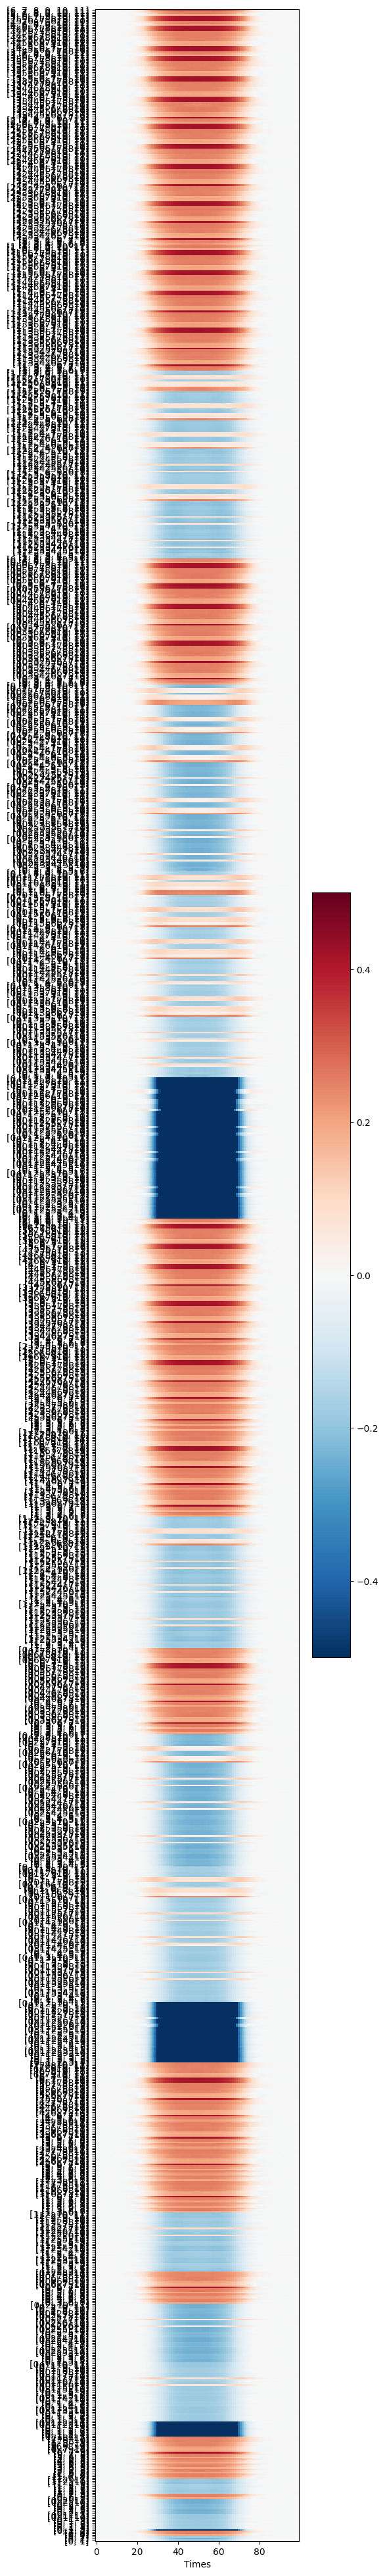

In [58]:
p_values1=np.where(pv.T<0.003,1,0)

plt.figure(figsize=(5,50))
index=np.where(np.sum(np.abs(goinfo*p_values1), axis=1)>0)[0]
plt.pcolormesh(
    variables, np.array(list_multiplets)[index], goinfo[index, :], cmap='RdBu_r', vmin=vmin, vmax=vmax
)

plt.colorbar()
plt.xlabel('Times')
plt.show()
plt.close()

In [40]:
len(index)

0

In [41]:
n_perm=500

goinfo=goinfo_create_fit_correction(data_features, target.T, minsize=minsize, maxsize=maxsize)

parallel, p_fun = parallel_func(goinfo_create_fit_correction, n_jobs=-1, total=n_perm)

perm = parallel(p_fun(data_features, np.random.permutation(target.T), minsize=minsize, maxsize=maxsize) for n_p in range(n_perm))

perm=np.array(perm)

    Copnorm data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          |  : 0/500 [00:00<?,       ?it/s]

    Copnorm data
Get list of multiplets
  0%|          |  0/3 [00:00<?,       ?it/s]    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
    Copnorm data
Get list of multiplets
    Copnorm data
  0%|          |  0/3 [00:00<?,       ?it/s]    Copnorm data
Get list of multiplets
Get list of multiplets
    Copnorm data
  0%|          |  0/3 [00:00<?,       ?it/s]    Copnorm data
    Copnorm data
  0%|          |  0/3 [00:00<?,       ?it/s]Get list of multiplets
Get list of multiplets
    Copnorm data
  0%|          |  0/3 [00:00<?,       ?it/s]Get list of multiplets
Get list of multiplets
  0%|          |  0/3 [00:00<?,       ?it/s]Get list of multiplets
Get list of multiplets
Get list of multiplets
  0%|          |  0/3 [00:00<?,       ?it/s]    Copnorm data
Get list of multiplets
    Copnorm data
  0%|          |  0/3 [00:00<?,       ?it/s]Get list of multiplets
 67%|██████▋   | Oinfo (3):  2/3 [00:02<00:01,    1.51s/it]

KeyboardInterrupt: 

In [17]:
effect_list=[goinfo_correct[np.newaxis, i,:] for i in range(len(goinfo[:,0]))]
perm_list=[perm[:,np.newaxis, i,:] for i in range(len(goinfo[:,0]))]

In [18]:
from frites.workflow import WfStats


In [19]:
inference='ffx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(effect_list, perm_list, inference=inference, mcp=mcp, tail=0)
# Mean II across subjects


Definition of a non-parametric statistical workflow
    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=0; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=0.0006542205810546875; tail=0)


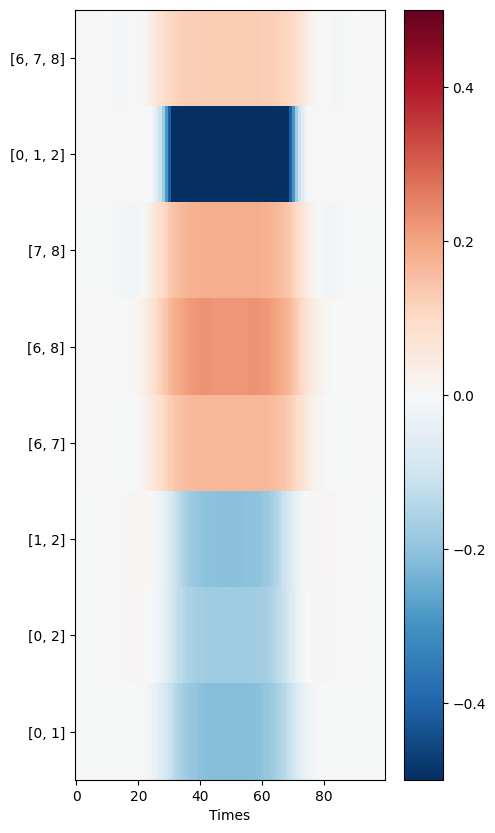

In [23]:
p_values1=np.where(pv.T<0.05,1,0)

plt.figure(figsize=(5,10))
index=np.where(np.sum(np.abs(goinfo_correct*p_values1), axis=1)>0)[0]
plt.pcolormesh(
    variables, np.array(list_multiplets)[index], goinfo_correct[index, :], cmap='RdBu_r', vmin=vmin, vmax=vmax
)

plt.colorbar()
plt.xlabel('Times')
plt.show()
plt.close()